In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as p
import numpy as np

In [2]:
dfb=pd.read_csv('2013---2015-dfb-ambulance.csv')
dfb['DTStart']=dfb[['Date','TOC']].apply(lambda x: ' '.join(x), axis=1)
dfb['DTStart']=pd.to_datetime(dfb['DTStart'],format="%d/%m/%Y %H:%M:%S")

New concept : [Resampling](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#resampling)

So resampling (whether it's up or downsampling) works in similar fashion as groupby but tailored for time series.

---

First gotcha : the Dataframe / Series must be using the Timestamp as the index :

In [3]:
dfb.index=dfb['DTStart']
dfb['TOC'].resample('15Min').count().head(10)

DTStart
2013-01-01 00:00:00    5
2013-01-01 00:15:00    3
2013-01-01 00:30:00    5
2013-01-01 00:45:00    4
2013-01-01 01:00:00    5
2013-01-01 01:15:00    3
2013-01-01 01:30:00    6
2013-01-01 01:45:00    5
2013-01-01 02:00:00    8
2013-01-01 02:15:00    5
Freq: 15T, Name: TOC, dtype: int64

You can see that now each rowis an aggregate of 15 mins, nothing really crazy but if you compare to the group by, it's much more straightforward to use in this context

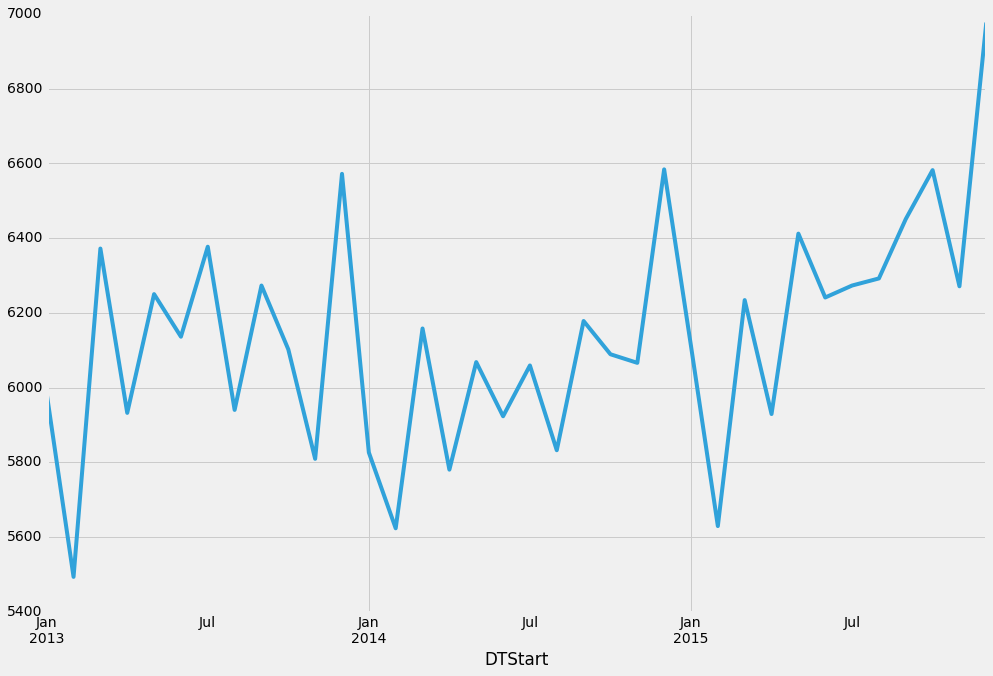

In [4]:
p.style.use('fivethirtyeight')
dfb['TOC'].resample('1M').count().plot(figsize=(15,10))

In [5]:
busiest_weeks=dfb['TOC'].resample('1W').count().sort_values(ascending=False)
busiest_weeks.index.to_series().dt.week.head(10)

DTStart
2015-12-20    51
2015-11-01    44
2015-12-06    49
2015-01-04     1
2015-12-27    52
2015-09-20    38
2015-09-27    39
2013-12-22    51
2013-09-29    39
2014-12-21    51
Name: DTStart, dtype: int64

Highlighting the busiest weeks.

---

Other new concept, selecting specific ranges.
Selecting can be done through various means and it's probably best to have a read through the [doc](http://pandas.pydata.org/pandas-docs/stable/indexing.html)

Here all rows for the week 51 :

In [6]:
dfb['Week'],dfb['Year']=dfb['DTStart'].dt.week,dfb['DTStart'].dt.year
dfb[dfb['Week']==51]['Station Area']

DTStart
2013-12-16 00:03:35     Dolphins Barn
2013-12-16 00:12:22           Finglas
2013-12-16 00:15:16          Tallaght
2013-12-16 00:17:12        Kilbarrack
2013-12-16 00:20:10    Blanchardstown
2013-12-16 00:24:42        Kilbarrack
2013-12-16 00:28:40    Blanchardstown
2013-12-16 00:28:30      Phibsborough
2013-12-16 00:36:22      North Strand
2013-12-16 00:37:25     Dolphins Barn
2013-12-16 00:44:13    Blanchardstown
2013-12-16 00:48:50    Blanchardstown
2013-12-16 00:51:36           Tara St
2013-12-16 00:57:26      North Strand
2013-12-16 01:03:55      Phibsborough
2013-12-16 01:06:46          Tallaght
2013-12-16 01:17:59      Phibsborough
2013-12-16 01:24:53      Phibsborough
2013-12-16 01:33:34           Finglas
2013-12-16 02:02:24    Blanchardstown
2013-12-16 02:09:33        Donnybrook
2013-12-16 02:25:38          Tallaght
2013-12-16 02:41:40          Skerries
2013-12-16 02:52:09       Rathfarnham
2013-12-16 02:57:17          Tallaght
2013-12-16 03:06:24           Tara St
2013

While the selection in Pandas is fairly powerful, getting the syntax right can be fairly challenging.

Here, selecting (in a loop) and plotting week 51 for each year :

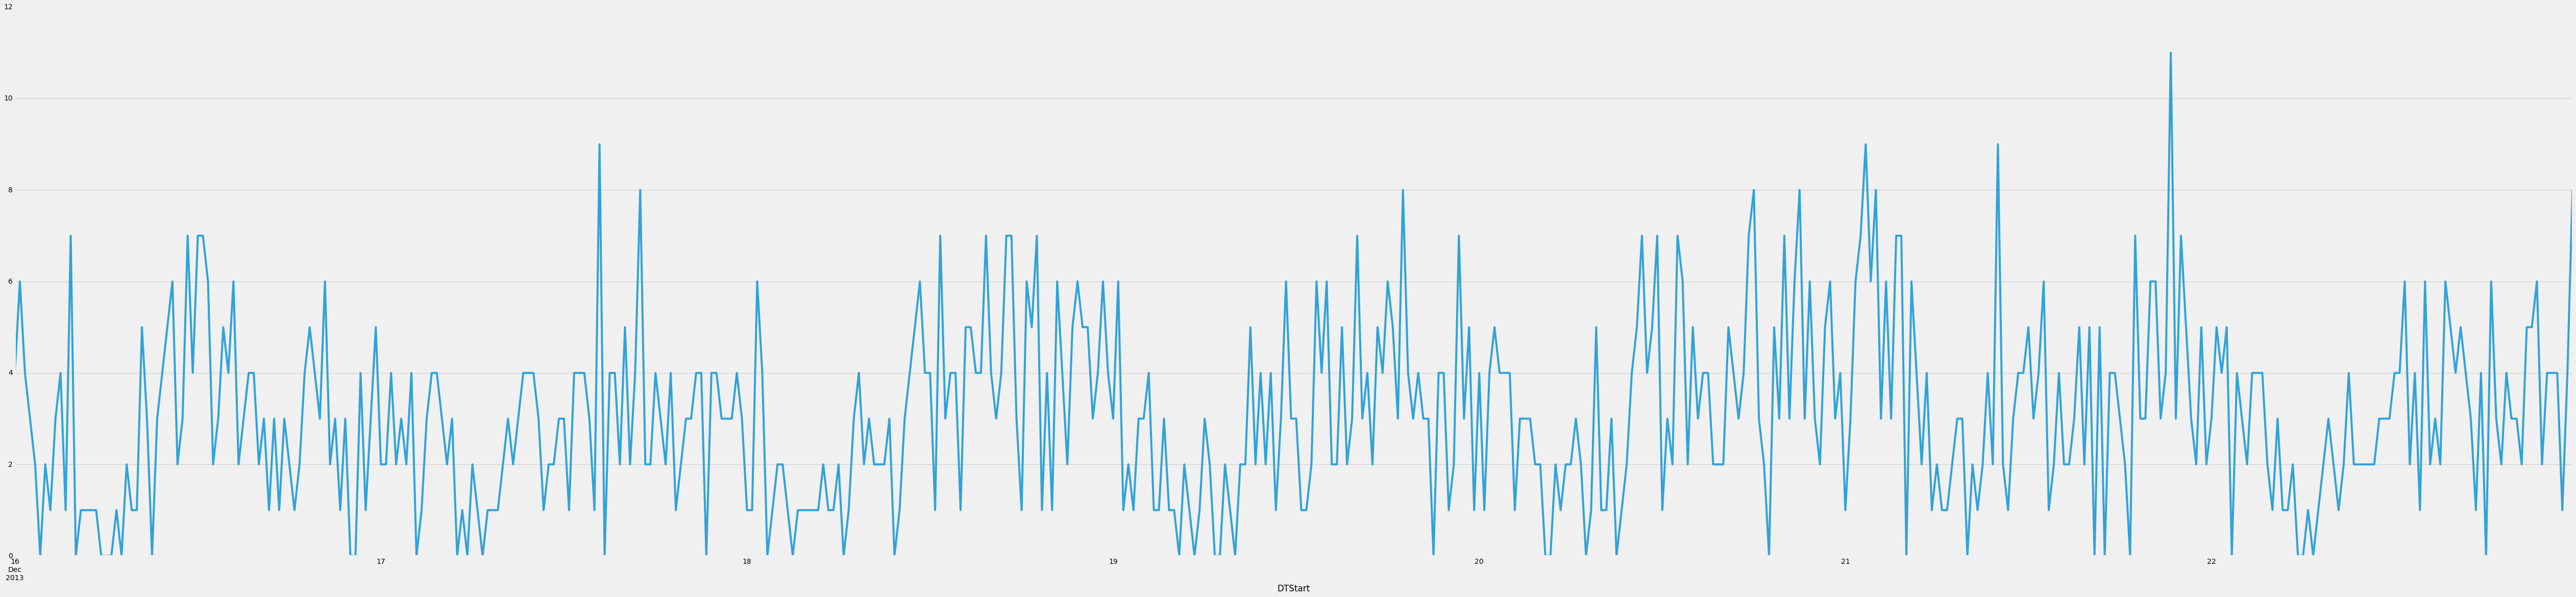

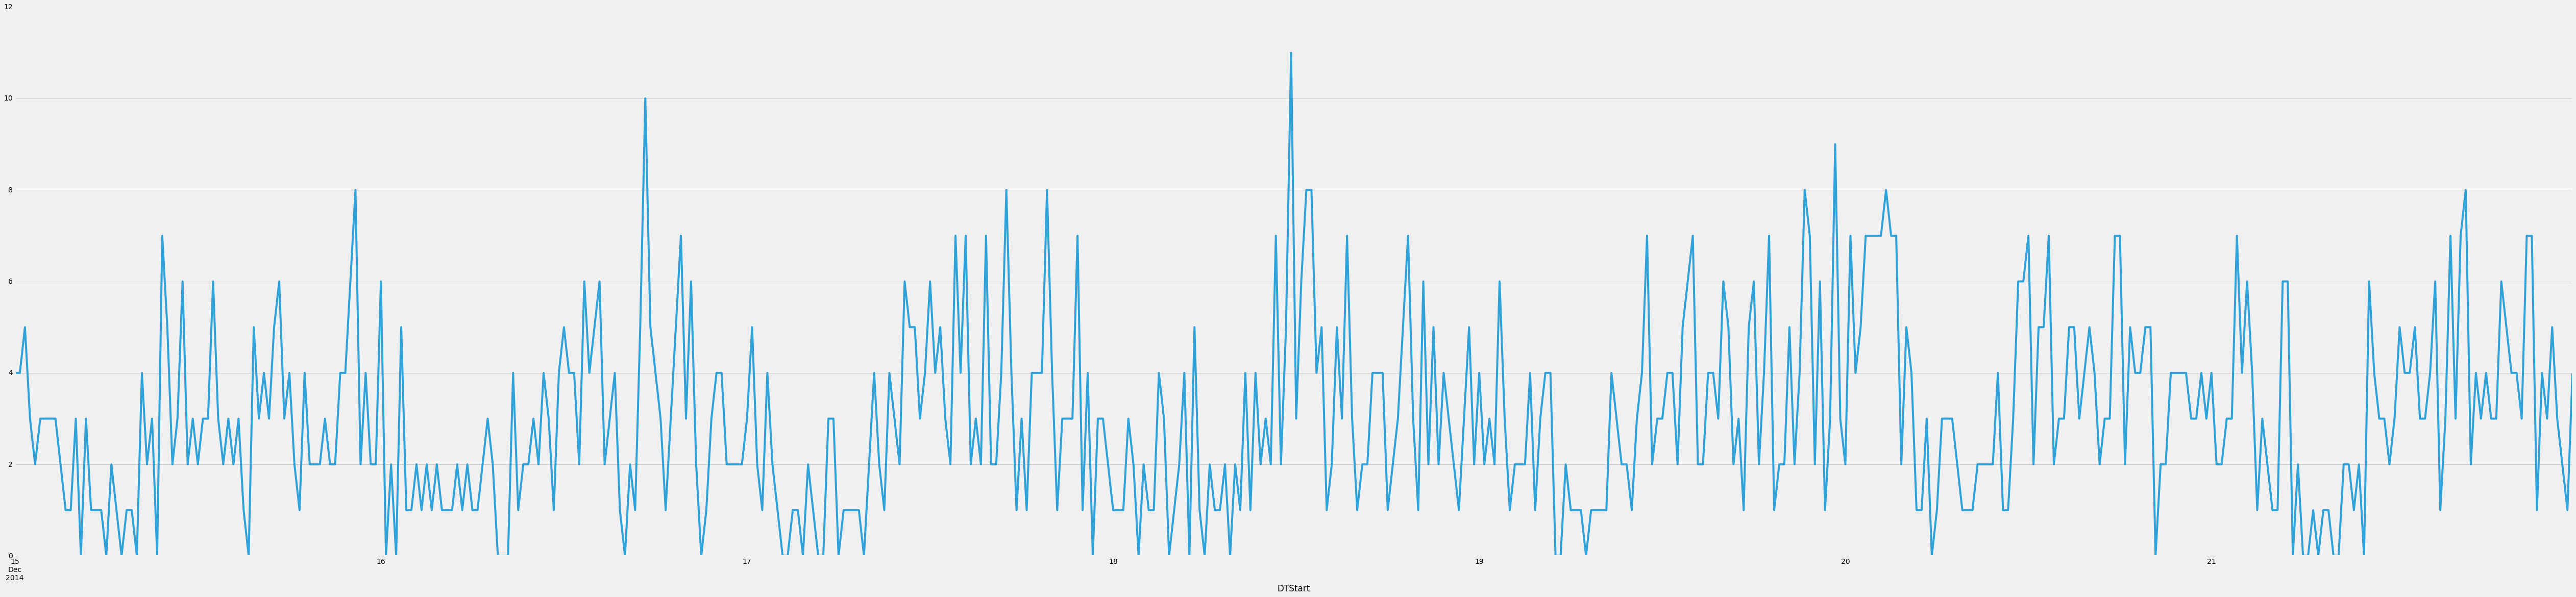

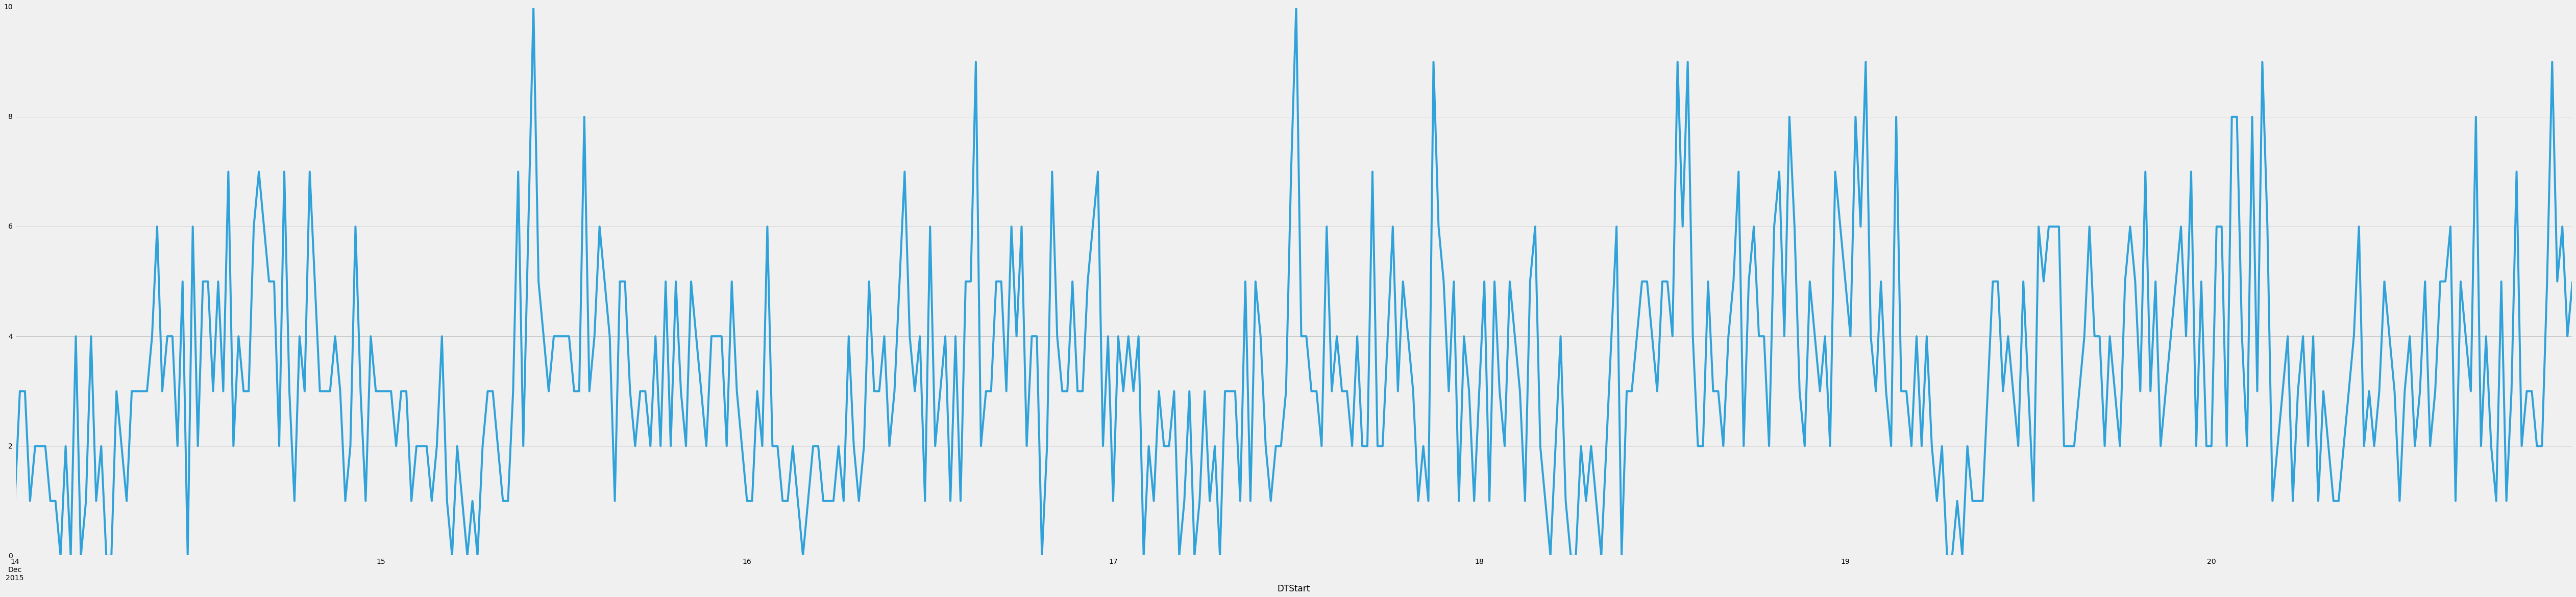

In [7]:
for year in range(2013,2016):
    dfb[(dfb['Week']==51) & (dfb['Year']==year)]['TOC'].resample('20Min').count().plot(figsize=(80,18))
    p.show()

Or selecting a specific range in the index (which here is a Time serie).

Pay attention to the format, there's no need to include a full range (here ommitting minutes & seconds while selecting from Christmas eve noon to Christmas day noon of 2015) :

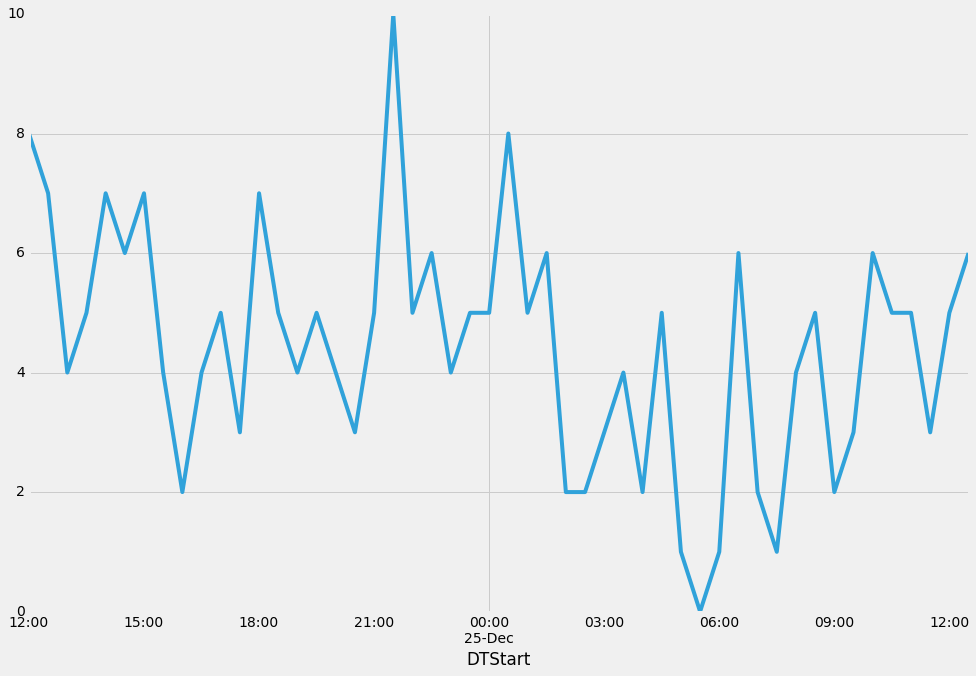

In [8]:
dfb['2015/12/24 12':'2015/12/25 12']['TOC'].resample("30min").count().plot(figsize=(15,10))

If we try to recreate the daily 'flow' from previous part but using the averaged rather than the absolute sum by combining selecting and resampling :

In [9]:
avg_day=dfb['TOC'].resample('30min').count()
hour_of_day=(avg_day.index.to_series().dt.minute+avg_day.index.to_series().dt.hour*60)/60
hour_of_day.sample(10)

DTStart
2015-09-18 23:30:00    23.5
2015-06-27 15:30:00    15.5
2014-10-19 16:00:00    16.0
2015-07-11 13:30:00    13.5
2015-12-07 16:00:00    16.0
2015-05-20 08:30:00     8.5
2013-05-08 14:00:00    14.0
2014-08-08 21:30:00    21.5
2015-11-24 19:00:00    19.0
2013-08-22 15:30:00    15.5
Name: DTStart, dtype: float64

First we resample and compute a value by hour of the day which will be used in our group by.

Then it's only a matter of plotting :

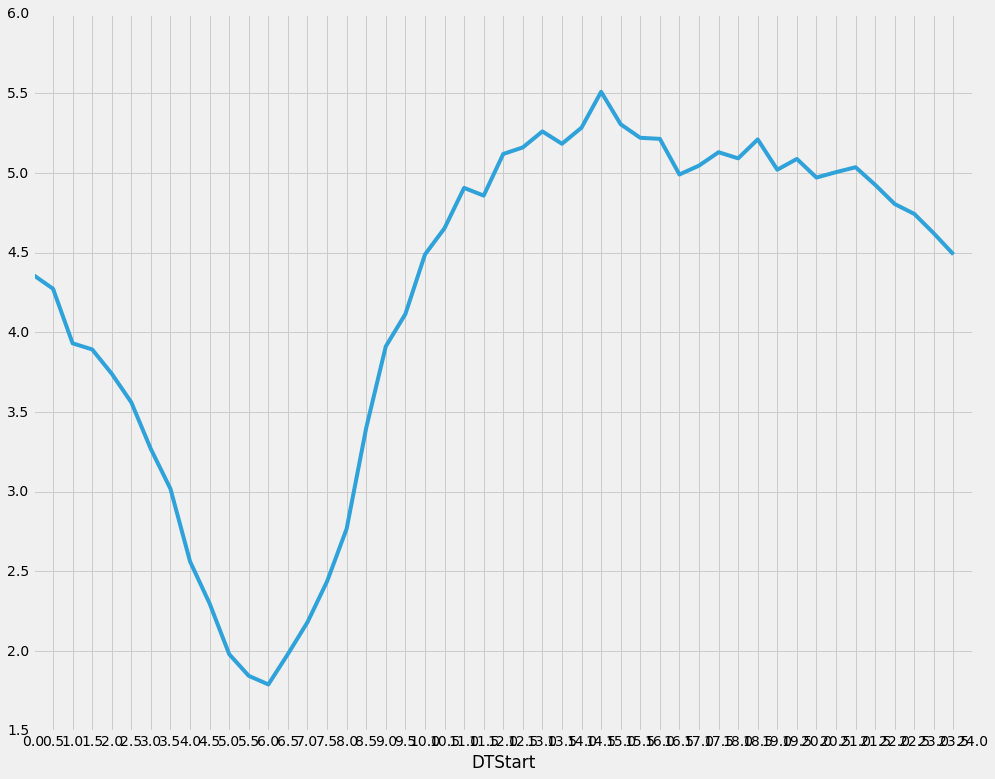

In [10]:
avg_day.groupby(hour_of_day).mean().plot(figsize=(15,12),xticks=np.linspace(0,24,49))

Unsurprisingly, it looks really similar to the graph using absolutes.

---

If we reuse the above concepts to highlight how the day goes by for each station :

In [11]:
global_avg=pd.DataFrame()
#create the final DataFrame outside of the loop

for place in dfb['Station Area'].unique():
#list every single Station and iterate over it    
    
    station_avg=dfb[dfb['Station Area']==place]['TOC'].resample('30min').count()
    #Select station and resample / aggregate
    
    global_avg[place]=station_avg.groupby(hour_of_day).mean()
    #Group by hour and compute the mean then push that to the final DF
    
global_avg.head(10)

,Tallaght,Tara St,Finglas,Dolphins Barn,Rathfarnham,Kilbarrack,Blanchardstown,Balbriggan,North Strand,Donnybrook,Phibsborough,Swords,Skerries,Dun Laoghaire,MH17,MH14,Dunshaughlin
DTStart,,,,,,,,,,,,,,,,,
0.0,0.692237,0.761644,0.416438,0.463437,0.212066,0.436929,0.300731,0.053016,0.209324,0.187386,0.443327,0.135283,0.032937,0.016514,0.0,0.003472,NaN
0.5,0.741553,0.716895,0.397260,0.450228,0.169863,0.413163,0.305302,0.063071,0.203839,0.198355,0.425046,0.136197,0.041171,0.012844,0.0,0.000000,1.0
1.0,0.642922,0.723288,0.359817,0.416438,0.170776,0.432877,0.230347,0.044790,0.184644,0.207495,0.365631,0.119744,0.025618,0.008257,0.0,0.000000,NaN
1.5,0.620091,0.727854,0.370776,0.431963,0.165297,0.395434,0.238356,0.040183,0.181735,0.209132,0.342779,0.127057,0.031107,0.011009,0.0,0.003472,NaN
2.0,0.576256,0.769863,0.327854,0.359817,0.166210,0.366210,0.238356,0.041096,0.194521,0.224658,0.329068,0.113346,0.028362,0.005505,0.0,0.000000,NaN
2.5,0.538813,0.730594,0.294064,0.360731,0.157991,0.354338,0.210959,0.056621,0.142466,0.219178,0.327854,0.133455,0.027447,0.006422,0.0,0.000000,NaN
3.0,0.512329,0.759817,0.258447,0.305936,0.126027,0.281279,0.190868,0.049315,0.173516,0.200000,0.253881,0.120658,0.030192,0.005505,0.0,0.000000,NaN
3.5,0.450228,0.669406,0.252968,0.308676,0.152511,0.265753,0.195434,0.035616,0.131507,0.179909,0.244749,0.100548,0.025618,0.005505,0.0,0.000000,NaN
4.0,0.400913,0.472146,0.218265,0.234703,0.120548,0.243836,0.187215,0.037443,0.124201,0.184475,0.228311,0.082267,0.021043,0.007339,0.0,0.000000,NaN


And now, plotting !

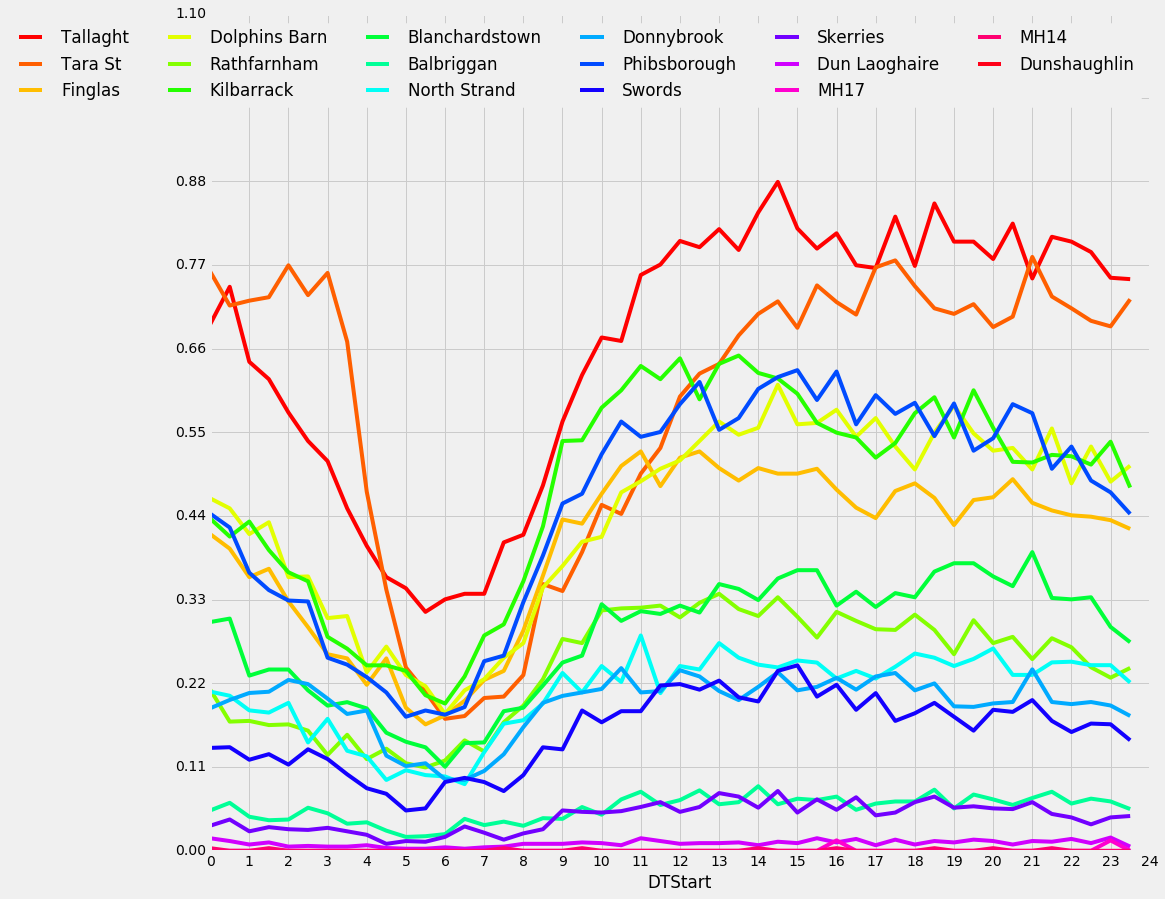

In [12]:
global_avg.plot(figsize=(15,14),xticks=np.linspace(0,24,25),colormap='hsv',yticks=np.linspace(0,1.1,11))
p.legend(ncol=6)

Looks like Tallaght and Tara Street are the top contenders.

It also appears that we're done for this round. 

Thank you for reading